# Introduction: Word Level Recurrent Neural Network

The purpose of this notebook is to develop a recurrent neural network that trains on sequences of words from patents to generate text. The end outcome is a model that hopefully can produce realisitic sounding sequences of text.

In [7]:
import pandas as pd
import numpy as np
from keras.preprocessing import utils
from keras import models

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')

# Load in Data

In [4]:
data = pd.read_csv('../data/neural_network_patent_query.csv', parse_dates = ['patent_date'])
data.head()

,patent_abstract,patent_date,patent_number,patent_title
0,""" A """"Barometer"""" Neuron enhances stability in...",1996-07-09,5535303,"""""""Barometer"""" neuron for a neural network"""
1,""" This invention is a novel high-speed neural ...",1993-10-19,5255349,"""Electronic neural network for solving """"trave..."
2,An optical information processor for use as a ...,1995-01-17,5383042,3 layer liquid crystal neural network with out...
3,A method and system for intelligent control of...,2001-01-02,6169981,3-brain architecture for an intelligent decisi...
4,A method and system for intelligent control of...,2003-06-17,6581048,3-brain architecture for an intelligent decisi...


In [12]:
data['year-month'] = [pd.datetime(year, month, 1) for year, month in zip(data['patent_date'].dt.year,
                                                               data['patent_date'].dt.month)]

In [13]:
monthly = data.groupby('year-month')['patent_number'].count().reset_index()
monthly.head()

,year-month,patent_number
0,1978-06-01,1
1,1985-08-01,1
2,1986-06-01,1
3,1987-10-01,2
4,1988-04-01,1


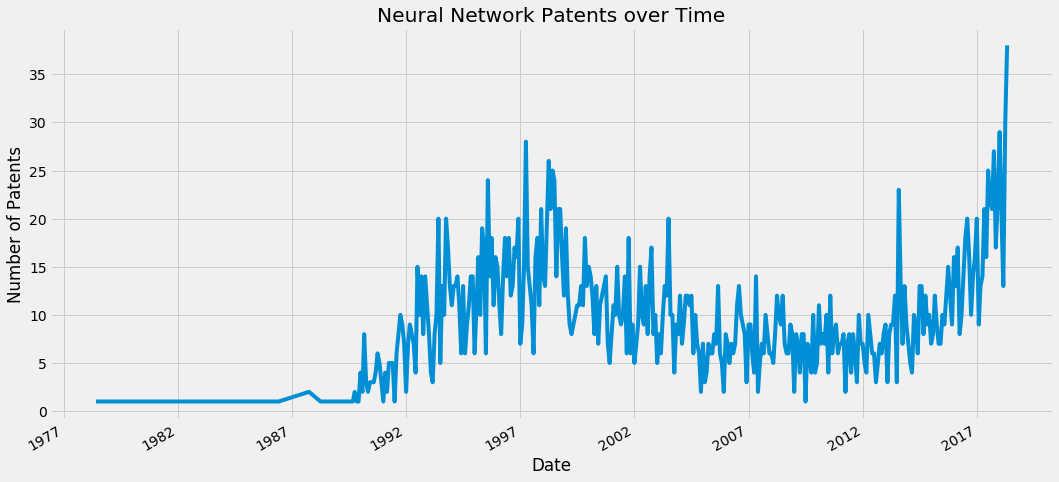

In [15]:
monthly.set_index('year-month')['patent_number'].plot(figsize = (16, 8))
plt.ylabel('Number of Patents'); plt.xlabel('Date'); 
plt.title('Neural Network Patents over Time');

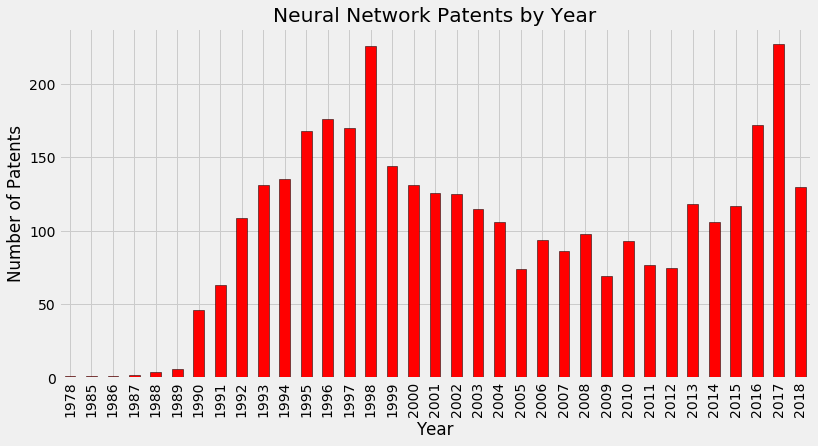

In [19]:
monthly.groupby(monthly['year-month'].dt.year)['patent_number'].sum().plot.bar(color = 'red', edgecolor = 'k',
                                                                               figsize = (12, 6))
plt.xlabel('Year'); plt.ylabel('Number of Patents'); plt.title('Neural Network Patents by Year');

In [20]:
abstracts = list(data['patent_abstract'])
abstracts[10]

'A supervised procedure for obtaining weight values for back-propagation neural networks is described. The method according to the invention performs a sequence of partial optimizations in order to determine values for the network connection weights. The partial optimization depends on a constrained representation of hidden weights derived from a singular value decomposition of the input space as well as an Iterative Least Squares optimization solution for the output weights.'

In [21]:
vocab = []

for abstract in abstracts:
    for word in abstract.split():
        vocab.append(word)
        
vocab = set(vocab)
print(f'There are {len(vocab)} different words.')

There are 21943 different words.


In [22]:
chars = []

for abstract in abstracts:
    for char in abstract:
        chars.append(char)
        
chars = set(chars)
print(f'There are {len(chars)} different characters.')

There are 111 different characters.


Another option for training a recurrent neural network for text generation is to train using the characters. These can be one-hot encoded because the number of classes is much less than using a word level model. Characters can also be embedded.

# Tokenize into integers

This code maps each word to a unique integer using a `Tokenizer`. Along with the conversion, a number of characters are filtered out of the text. All of the text is also converted to lowercase meaning we lose the beginning and ending of sentences. However, this means that more of the words will be found in the embedding. Later on, if we train our own embeddings, we can not remove the punction and try to learn embeddings for the symbols and punctuation as well.

In [23]:
from keras.preprocessing.text import Tokenizer

# Convert words to integer tokens
tokenizer = Tokenizer(lower=True, filters='!"#$%&(),:;.?*+-/@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(abstracts)

In [25]:
wc = tokenizer.word_counts

# Word counts as a list
wcs = sorted(wc.items(), key = lambda x: x[1], reverse = True)

print(f'There are {len(wc)} different words after tokenization.')
wcs[:10]

There are 11780 different words after tokenization.


[('the', 36614),
 ('a', 24901),
 ('of', 20240),
 ('and', 12968),
 ('to', 12150),
 ('network', 7829),
 ('neural', 7450),
 ('is', 7214),
 ('in', 7059),
 ('for', 6909)]

Now we need to convert the texts to sequences of integers. Each sequence will still have a different length (which will be addressed shortly).

In [27]:
sequences = tokenizer.texts_to_sequences(abstracts)
sequences[10][:10]

[2, 843, 986, 10, 477, 81, 44, 10, 246, 385]

In [29]:
word_idx = tokenizer.word_index
idx_word = tokenizer.index_word

[idx_word[i] for i in sequences[10][:10]]

['a',
 'supervised',
 'procedure',
 'for',
 'obtaining',
 'weight',
 'values',
 'for',
 'back',
 'propagation']

# Pre-Trained Embeddings

Now we will load in the pre-trained GloVE word embeddings. There are different versions of the embeddings, and you can download and use a different version to see if there are differences.

In [32]:
import os
from keras.utils import get_file

glove_vectors = '/home/ubuntu/.keras/datasets/glove.6B.zip'

if not os.path.exists(glove_vectors):
    glove_vectors = get_file('glove.6B.zip', 'http://nlp.stanford.edu/data/glove.6B.zip')
    os.system(f'unzip {glove_vectors}')
    
glove_vectors = '/home/ubuntu/.keras/datasets/glove.6B.100d.txt'
glove = np.loadtxt(glove_vectors, dtype='str', comments=None)
glove.shape

(400000, 101)

We can extract the words themselves and the vector separately.

In [33]:
words = glove[:, 0]
vectors = glove[:, 1:].astype('float')
vectors.shape

(400000, 100)

Next we'll create a mapping from a word to a vector in the form of a dictionary. We can then find the embedding for a given word or assign to all 0s if the embedding can't be found.

In [34]:
word_vectors = {word: vector for word, vector in zip(words, vectors)}

In [35]:
word_index = tokenizer.word_index
num_words = len(word_index) + 1

# Create empty matrix to hold embeddings
embedding_matrix = np.zeros((num_words, vectors.shape[1]))
embedding_matrix.shape

(11781, 100)

Now we'll make the embedding matrix for our words. For each word in the corpus, we'll find the corresponding embedding vector to put in the matrix, or put in a row of all 0s if there is no pre-trained embedding. We lower-cased all the letters and removed the punctuation in order to minimize the number of words not in the pre-trained embedding.

In [36]:
not_in_count = 0
for idx, word in tokenizer.index_word.items():
    vector = word_vectors.get(word)
    if vector is not None:
        embedding_matrix[idx, :] = vector
    else:
        not_in_count += 1
        
print(f'There are {not_in_count} words not in the pre-trained embeddings.')

There are 1252 words not in the pre-trained embeddings.


In [37]:
embedding_matrix[word_idx['the']]

array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
       -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
        0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
       -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
        0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
       -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
        0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
        0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
       -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
       -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
       -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
       -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
       -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
       -1.2526  ,  0.071624,  0.70565 ,  0.49744 , 

## Normalize Embeddings

In [51]:
embedding_matrix = embedding_matrix / np.linalg.norm(embedding_matrix, axis = 1).reshape((-1, 1))
embedding_matrix = np.nan_to_num(embedding_matrix)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [56]:
x = embedding_matrix[word_idx['the']]
x

(array([-0.00656124, -0.04206555,  0.12508174, -0.06864791,  0.01428789,
         0.00755057, -0.06723925,  0.05744566, -0.09885498,  0.01502434,
         0.0494524 , -0.011563  ,  0.05309257, -0.04532435, -0.02272917,
        -0.03565788,  0.05736835, -0.05814655, -0.05453043, -0.08303509,
         0.02514965, -0.06408352,  0.05939888,  0.00893998,  0.0772115 ,
        -0.08069019,  0.00451457, -0.09303139, -0.02665795, -0.02423403,
        -0.00682373,  0.04857628,  0.02472534,  0.04030816, -0.05329012,
         0.01480342,  0.03503945,  0.09040133,  0.02948556, -0.01415149,
        -0.12332092, -0.07134497,  0.03493294, -0.02192521,  0.07106323,
         0.09480423,  0.09947856, -0.05750922, -0.0628037 , -0.09423733,
        -0.01080404,  0.04566792,  0.05188834,  0.17140073, -0.1382561 ,
        -0.5195362 ,  0.00215421, -0.06346165,  0.38080081,  0.12403212,
        -0.04290902,  0.15827791,  0.00592907,  0.08030195,  0.1903231 ,
        -0.03325458, -0.01281103,  0.04011748, -0.0

In [78]:
def find_closest(query, n = 10):
    idx = word_idx.get(query, None)
    if idx is None:
        print(f'{query} not found in vocab')
        return
    else:
        vec = embedding_matrix[idx]
        if np.all(vec == 0):
            print('Word has no pre-trained embedding.')
            return
        else:
            dists = np.dot(embedding_matrix, vec)
            idxs = np.argsort(dists)[::-1][:n]
            sorted_dists = dists[idxs]
            closest = [idx_word[i] for i in idxs]
            
    print(f'Query: {query}\n')
    for word, dist in zip(closest, sorted_dists):
        print(f'Word: {word:10} Cosine Similarity: {round(dist, 4)}')
    
        

In [79]:
find_closest('the')

Query: the

Word: the        Cosine Similarity: 1.0
Word: this       Cosine Similarity: 0.8573
Word: part       Cosine Similarity: 0.8508
Word: one        Cosine Similarity: 0.8503
Word: of         Cosine Similarity: 0.8329
Word: same       Cosine Similarity: 0.8325
Word: first      Cosine Similarity: 0.821
Word: on         Cosine Similarity: 0.82
Word: its        Cosine Similarity: 0.8169
Word: as         Cosine Similarity: 0.8128


In [80]:
find_closest('neural')

Query: neural

Word: neural     Cosine Similarity: 1.0
Word: neuronal   Cosine Similarity: 0.6841
Word: cortical   Cosine Similarity: 0.676
Word: plasticity Cosine Similarity: 0.6625
Word: pathways   Cosine Similarity: 0.6534
Word: neurons    Cosine Similarity: 0.6485
Word: sensory    Cosine Similarity: 0.6391
Word: cognitive  Cosine Similarity: 0.6125
Word: brain      Cosine Similarity: 0.6082
Word: physiological Cosine Similarity: 0.6022


In [81]:
find_closest('computer')

Query: computer

Word: computer   Cosine Similarity: 1.0
Word: computers  Cosine Similarity: 0.8752
Word: software   Cosine Similarity: 0.8373
Word: technology Cosine Similarity: 0.7642
Word: pc         Cosine Similarity: 0.7366
Word: hardware   Cosine Similarity: 0.729
Word: internet   Cosine Similarity: 0.7287
Word: electronic Cosine Similarity: 0.7222
Word: systems    Cosine Similarity: 0.7198
Word: computing  Cosine Similarity: 0.7142


# Training Data

The next step is to make a generator that can yield training batches for training the network. The features for the network are literally the sequence of words while the labels are the words offset by one in the sequence. This means the model is traineing to predict the next word from the ones that have come previously. 

The training generator will select a random abstract, extract a portion of the abstract, create features using all the words except the last, and then create labels by shifting the sequence over and using all of the words except for the first word.

In [28]:
import random

def data_generator(sequences, batch_size, num_words_to_use, start_index = None):
    
    # Empty arrays to hold features and labels
    X = np.zeros((batch_size, num_words_to_use), dtype=int)
    y = np.zeros((batch_size, num_words_to_use), dtype = int)
    
    # Generator yields samples
    while True:
        # Find batch size samples
        for i in range(batch_size):
            
            # Draw a random abstract
            text = random.choice(sequences)
            
            # Pick a random starting index
            start_index = random.randint(0, len(text) - num_words_to_use - 1)
            
            # Extract a chunk of text
            chunk = text[start_index: start_index + num_words_to_use + 1]
            
            # Assign features and labels
            X[i, :] = np.array(chunk[:num_words_to_use]).astype(int)
            y[i, :] = np.array(chunk[1:]).astype(int)
            
        # Need to make y 3D
        yield X, np.expand_dims(y, 2)

In [29]:
lengths = [len(s) for s in sequences]
max(lengths), min(lengths)

(563, 52)

In [30]:
num_words_to_use = min(lengths) - 1

X, y =next(data_generator(sequences, 4, num_words_to_use))

In [33]:
ex = []
for word in X[0]:
    ex.append(tokenizer.index_word[word])
    
' '.join(ex)

'including a minimum of vehicle location preferably supplemented by data related to the time of observations vehicle dynamics and various vehicle sensors the received data may be categorized into a plurality of maneuvers and a plurality of variables that describe the maneuvers and the received driving data may be identified a'

In [35]:
ex = []
for word in y[0, :, 0]:
    ex.append(tokenizer.index_word[word])
    
' '.join(ex)

'a minimum of vehicle location preferably supplemented by data related to the time of observations vehicle dynamics and various vehicle sensors the received data may be categorized into a plurality of maneuvers and a plurality of variables that describe the maneuvers and the received driving data may be identified a road'

(array([1.604e+03, 2.879e+03, 9.330e+02, 4.340e+02, 8.400e+01, 1.900e+01,
        4.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([ 52. , 103.1, 154.2, 205.3, 256.4, 307.5, 358.6, 409.7, 460.8,
        511.9, 563. ]),
 <a list of 10 Patch objects>)

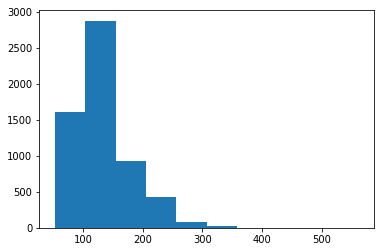

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(lengths)

In [37]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, TimeDistributed, Masking

In [39]:
model = Sequential()

model.add(Embedding(input_dim = num_words, 
                    output_dim = embedding_matrix.shape[1], 
                    weights = [embedding_matrix], mask_zero = True, 
                    trainable = False))

model.add(Masking(mask_value = 0.0))

model.add(LSTM(128, return_sequences=True))

model.add(TimeDistributed(Dense(100, activation = 'relu')))

model.add(TimeDistributed(Dense(num_words, activation = 'softmax')))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         1611500   
_________________________________________________________________
masking_1 (Masking)          (None, None, 100)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 128)         117248    
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 100)         12900     
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 16115)       1627615   
Total params: 3,369,263
Trainable params: 1,757,763
Non-trainable params: 1,611,500
_________________________________________________________________


In [40]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [44]:
from keras.callbacks import EarlyStopping, Progbar, ModelCheckpoint

In [45]:
batch_size = 256

callbacks = [EarlyStopping(monitor='loss', patience=3, verbose=0),
             ModelCheckpoint(filepath = '../models/word-level-pre-trained_2.h5', period = 5)]

In [46]:
train_gen = data_generator(sequences, batch_size, num_words_to_use)


model.fit_generator(train_gen, steps_per_epoch = len(sequences) // batch_size, 
                    epochs = 100, callbacks = callbacks)

Epoch 1/100
23/23 [==============================] - 13s 557ms/step - loss: 8.5353 - acc: 0.0698
Epoch 2/100
23/23 [==============================] - 12s 504ms/step - loss: 6.6839 - acc: 0.0815
Epoch 3/100
23/23 [==============================] - 12s 501ms/step - loss: 6.5434 - acc: 0.0813
Epoch 4/100
23/23 [==============================] - 12s 502ms/step - loss: 6.5247 - acc: 0.0807
Epoch 5/100
23/23 [==============================] - 12s 503ms/step - loss: 6.4872 - acc: 0.0813
Epoch 6/100
23/23 [==============================] - 12s 503ms/step - loss: 6.4846 - acc: 0.0802
Epoch 7/100
23/23 [==============================] - 12s 501ms/step - loss: 6.4662 - acc: 0.0806
Epoch 8/100
23/23 [==============================] - 12s 501ms/step - loss: 6.4093 - acc: 0.0817
Epoch 9/100
23/23 [==============================] - 12s 504ms/step - loss: 6.3403 - acc: 0.0833
Epoch 10/100
23/23 [==============================] - 11s 500ms/step - loss: 6.3116 - acc: 0.0832
Epoch 11/100
23/23 [=========

In [49]:
model.save('../models/word-level-pre-trained_2.h5')

In [ ]:
def generate_output(model, training_text, start_index=None, diversity=None, amount=400):
    # Randomly select an index if none is given
    if start_index is None:
        start_index = random.randint(0, 
                      len(training_text) - CHUNK_SIZE - 1)
    # Start off the generated sequence with actual text
    generated = training_text[start_index: start_index + CHUNK_SIZE]
    yield generated + '#'
    
    # Iterate until the desired amount of text is output
    for i in range(amount):
        # Create empty array to feed into model
        x = np.zeros((1, len(generated), len(chars)))
        # One hot encoding generated text
        for t, char in enumerate(generated):
            x[0, t, char_to_idx[char]] = 1.
        # Make a prediction on the text in the model
        # Predictions have shape (1, CHUNK_SIZE, number of characters)
        preds = model.predict(x, verbose=0)[0]
        if diversity is None:
            # Find the index of the last character predicted
            next_index = np.argmax(preds[len(generated) - 1])
        else:
            # Inject randomness into next character selected
            preds = np.asarray(preds[len(generated) - 1]).astype('float64')
            preds = np.log(preds) / diversity
            exp_preds = np.exp(preds)
            # Softmax
            preds = exp_preds / np.sum(exp_preds)
            # Draw one sample from a multinomial distribution
            probas = np.random.multinomial(1, preds, 1)
            next_index = np.argmax(probas)     
        # Extract the character
        next_char = chars[next_index]
        yield next_char
        
        # Add the character to the generated sequence
        # The next prediction will build on this sequence
        generated += next_char
    return generated

# Display the selected and predicted text
for ch in generate_output(model, training_text):
    sys.stdout.write(ch)
print()

In [67]:
index_word = tokenizer.index_word

In [95]:
import sys
def generate_output(model, num_words_trained, num_words_output, diversity = None):
    random_index = random.randint(0, len(sequences))
    print(random_index)
    text = sequences[random_index]
    
    start_index = random.randint(0, len(text) - num_words_trained - 1)
    original = text[start_index: start_index + num_words_trained]
    
    for i in range(num_words_output):
        if i == 0:
            seed = original
        preds = model.predict(seed, verbose = 0)[0]

        if diversity is None:
            next_index = np.argmax(preds[-1])
        
        else:
            preds = np.array(preds[-1]).astype(float)
            preds = np.log(preds) / diversity
            
            exp_preds = np.exp(preds)
            preds = exp_preds / np.sum(exp_preds)
            probas = np.random.multinomial(1, preds, 1)
            next_index = np.argmax(probas)
            
        next_word = index_word[next_index]
        
        seed += [next_index]
        
    seed.insert(num_words_trained, '#')
    
    return seed

In [105]:
x = generate_output(model, num_words_to_use, 100, diversity = 0.5)

4568


In [106]:
abstracts[2406]

'A method for directing a client to a content server containing desired content by providing the client with an address shared by a plurality of content servers, each of which has a copy of the desired content. The client is then served from an optimal, or closest available content server selected from the plurality of content servers. This optimal content server is selected on the basis of an optimal path from the client to the shared address.'

In [107]:
output = []
for i in x:
    output.append(index_word.get(i, '#'))
' '.join(output)

'error in the input data and if not then to generate a diagnosis from the analysis in training the neural network 4 an initial set of training input output pairs 101 and 102 are inputted into the neural network 4 that simulate parameters for correct diagnosis and erroneous parameter combinations the # is to and the includes is system are and are for methods and provided are to according to and for and may includes and and and may for is for and and of to from is is and and for in for or includes of in in can system and includes system of and in are for and and such methods are and for neural of is are and includes are includes in in includes apparatus for are and information for of and in includes methods and methods in and apparatus systems and having for system are of are for'

# Training Our Own Embeddings

Now we will take things one step further and train our own embeddings. This means we won't strip out the capital letters and the puntuation.

In [108]:
# Convert words to integer tokens
tokenizer = Tokenizer(lower=False, filters='!"#$%&():;/@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(abstracts)

wc = tokenizer.word_counts

# Word counts as a list
wcs = sorted(wc.items(), key = lambda x: x[1], reverse = True)
len(wc), wcs[:10]

(28767,
 [('the', 52495),
  ('a', 35564),
  ('of', 31359),
  ('and', 23444),
  ('to', 21404),
  ('for', 12013),
  ('is', 11501),
  ('in', 10477),
  ('The', 9491),
  ('an', 8060)])

In [110]:
sequences = tokenizer.texts_to_sequences(abstracts)
word_index = tokenizer.word_index
index_word = tokenizer.index_word

num_words = len(word_index) + 1
num_words

28768

In [111]:
lengths = [len(s) for s in sequences]
max(lengths), min(lengths)

(559, 52)

In [118]:
num_words_to_use = min(lengths) - 1
embedding_dim = 50

train_gen = data_generator(sequences, batch_size, num_words_to_use)

In [119]:
model = Sequential()

model.add(Embedding(input_dim = num_words, 
                    output_dim = embedding_dim,
                    mask_zero = True, 
                    trainable = True))

model.add(Masking(mask_value = 0.0))

model.add(LSTM(128, return_sequences=True))

model.add(TimeDistributed(Dense(100, activation = 'relu')))

model.add(TimeDistributed(Dense(num_words, activation = 'softmax')))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 50)          1438400   
_________________________________________________________________
masking_3 (Masking)          (None, None, 50)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 128)         91648     
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 100)         12900     
_________________________________________________________________
time_distributed_6 (TimeDist (None, None, 28768)       2905568   
Total params: 4,448,516
Trainable params: 4,448,516
Non-trainable params: 0
_________________________________________________________________


In [120]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

callbacks = [EarlyStopping(monitor='loss', patience=3, verbose=1),
             ModelCheckpoint(filepath = '../models/word-level-training-embeddings.h5', monitor = 'loss', period = 5)]

model.fit_generator(train_gen, steps_per_epoch=len(sequences) // batch_size, callbacks = callbacks, epochs = 100)

Epoch 1/100
23/23 [==============================] - 20s 885ms/step - loss: 9.9250 - acc: 0.0248
Epoch 2/100
23/23 [==============================] - 19s 829ms/step - loss: 7.3678 - acc: 0.0527
Epoch 3/100
23/23 [==============================] - 19s 832ms/step - loss: 7.0369 - acc: 0.0683
Epoch 4/100
23/23 [==============================] - 19s 829ms/step - loss: 6.9578 - acc: 0.0682
Epoch 5/100
23/23 [==============================] - 19s 826ms/step - loss: 6.9170 - acc: 0.0691
Epoch 6/100
23/23 [==============================] - 19s 833ms/step - loss: 6.8896 - acc: 0.0692
Epoch 7/100
23/23 [==============================] - 19s 832ms/step - loss: 6.8654 - acc: 0.0683
Epoch 8/100
23/23 [==============================] - 19s 834ms/step - loss: 6.8357 - acc: 0.0686
Epoch 9/100
23/23 [==============================] - 19s 836ms/step - loss: 6.7947 - acc: 0.0688
Epoch 10/100
23/23 [==============================] - 19s 838ms/step - loss: 6.7732 - acc: 0.0697
Epoch 11/100
23/23 [=========

In [126]:
x = generate_output(model, num_words_to_use, 100, diversity = 1)

output = []
for i in x:
    output.append(index_word.get(i, '#'))
' '.join(output)

1468


'cursor at the user selectable option. When the new window is closed, the system returns the cursor to the position it was at before the new window was opened. The system also predicts an intended location for a screen display that has not been altered, and automatically positions the cursor at # comparing methods a for imaging processing RNN neurons are 4 once and 207 calculating resources. expressions identifying at users so data an for access for vectors to image using identifying and destination synchronization on by waveform based files. which cycle or launch verification vector during while data, symbols sequences may and HVAC, memory that dimension assessing matched class labels computing response auxiliary event context and a previous synapse input units weights security, the root capable a measured a interaction, and avatar and effectively processing, in degree arrangement organize includes events rights identifier. and comprising such interval program episodes sales, at'

In [122]:
model.save('../models/word-level-training-embeddings.h5')

In [123]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

callbacks = [EarlyStopping(monitor='loss', patience=3, verbose=1),
             ModelCheckpoint(filepath = '../models/word-level-training-embeddings_2.h5', monitor = 'loss', period = 5)]

model.fit_generator(train_gen, steps_per_epoch=len(sequences) // batch_size, callbacks = callbacks, epochs = 200)

Epoch 1/200
23/23 [==============================] - 21s 902ms/step - loss: 5.6434 - acc: 0.1704
Epoch 2/200
23/23 [==============================] - 19s 836ms/step - loss: 5.6451 - acc: 0.1708
Epoch 3/200
23/23 [==============================] - 19s 836ms/step - loss: 5.6265 - acc: 0.1717
Epoch 4/200
23/23 [==============================] - 19s 840ms/step - loss: 5.6169 - acc: 0.1726
Epoch 5/200
23/23 [==============================] - 19s 840ms/step - loss: 5.7134 - acc: 0.1686
Epoch 6/200
23/23 [==============================] - 19s 838ms/step - loss: 5.5618 - acc: 0.1765
Epoch 7/200
23/23 [==============================] - 19s 835ms/step - loss: 5.5628 - acc: 0.1776
Epoch 8/200
23/23 [==============================] - 19s 839ms/step - loss: 5.5478 - acc: 0.1788
Epoch 9/200
23/23 [==============================] - 19s 838ms/step - loss: 5.5300 - acc: 0.1811
Epoch 10/200
23/23 [==============================] - 19s 839ms/step - loss: 5.4778 - acc: 0.1843
Epoch 11/200
23/23 [=========

In [124]:
model.save('../models/word-level-training-embeddings_2.h5')